In [ ]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "src")))


from data_loading.extract_indices import extract_trajectory_indices
from data_loading.load_data import load_dataset


# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 임의의 하이퍼파라미터 설정
latent_dim = 64  # 인코더에서 나오는 잠재 공간 차원
batch_size = 32
num_epochs = 100  # 학습 에폭 수
env_name = "box-close-v2"
# env_name = "sweep-v2"
# env_name = "button-press-topdown-v2"
# env_name = "dial-turn-v2"
exp_name_base = "AESPA-15"
pair_algo = "ternary-200"
TRAJECTORY_LENGTH=25


dataset = load_dataset(env_name=env_name)
indices = extract_trajectory_indices(dataset)
cum_sum = np.cumsum(dataset["rewards"], dtype=np.float64)
average_reward = np.mean(dataset["rewards"])
average_success = np.mean(dataset["success"])

success_traj = 0

for i, e in indices:
    success = dataset["success"][i:e].sum()
    if success > 0:
        success_traj += 1



print ("ENV", env_name)
print("average reward", average_reward)
print("average success", average_success)
print("success traj ratio", success_traj / len(indices))


trajectory counts 4800
ENV box-close-v2
average reward 1.0545156
average success 0.039954583333333335
success traj ratio 0.08041666666666666


In [17]:
for i in range(0, 101, 5):
    print (i, np.percentile(dataset["rewards"], i))

print (np.std(dataset["rewards"]))

0 0.0
5 0.0
10 0.0
15 0.011549358488991851
20 0.14963063895702364
25 0.21385451778769493
30 0.2581173330545425
35 0.3019820034503936
40 0.348339456319809
45 0.3897775799036026
50 0.42866045236587524
55 0.4776712313294412
60 0.5571324110031126
65 0.6776732444763184
70 0.827820605039596
75 1.0295985639095306
80 1.3056272268295288
85 1.5001691043376921
90 2.523897957801819
95 4.373603534698477
100 9.992400169372559
1.8709017


In [2]:
from reward_learning.reward_model_base import RewardModelBase


def fill_feedback_from_model(dataset, pairs, model: RewardModelBase):
    """
    Fill feedback in dataset using multiple reward models and average their mu values.
    Also return the standard deviation of mu values.

    Args:
        dataset: dict
        pairs: list of tuples ((int, int), (int, int))
        models: list of torch.nn.Module
        linear_loss: bool, optional
            If True, use linear loss for mu calculation. Default is False.

    Returns:
        tuple:
            - np array of ((int, int), (int, int), float): mu values.
            - np array of float: standard deviation of mu values.
    """

    num_samples = len(dataset["observations"])
    batch_size = num_samples // 20
    model_outputs = []

    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)

        obs_batch = torch.tensor(
            dataset["observations"][start_idx:end_idx], dtype=torch.float32
        ).to(device)
        act_batch = torch.tensor(
            dataset["actions"][start_idx:end_idx], dtype=torch.float32
        ).to(device)

        rewards = model(
            obs_batch, act_batch
        )

        model_outputs.append(rewards.detach().cpu().numpy())

    predicted_rewards = np.concatenate(model_outputs, axis=0).squeeze()
    cumulative_rewards = np.cumsum(predicted_rewards, dtype=np.float64)

    feedbacks = []

    for i0, i1 in pairs:
        s0, e0 = i0
        s1, e1 = i1

        sum_of_rewards_0 = cumulative_rewards[e0 - 1] - (
            cumulative_rewards[s0 - 1] if s0 > 0 else 0
        )
        sum_of_rewards_1 = cumulative_rewards[e1 - 1] - (
            cumulative_rewards[s1 - 1] if s1 > 0 else 0
        )

        mu = sum_of_rewards_1 / (sum_of_rewards_0 + sum_of_rewards_1)

        feedbacks.append(((s0, e0), (s1, e1), mu))

    return feedbacks

In [3]:
from data_generation.classifier.trajectory_pair_classifier import TrajectoryPairClassifier
from data_loading.load_data import load_pair
from data_loading.preference_dataloader import get_dataloader
from reward_learning.get_model import get_reward_model
from utils.path import get_reward_model_path, get_trajectory_pair_classifier_path


classifier_data = []
reward_model_data = []

test_pair_algo = "ternary-100000"


# Accuracy 계산용 함수
def categorize_mu(mu_value):
    if mu_value < 1 / 3:
        return 0.0
    elif mu_value > 2 / 3:
        return 1.0
    else:
        return 0.5

for i in range(0, 10):
    exp_name = f"{exp_name_base}-{i:02d}"

    test_loader = get_dataloader(
            env_name=env_name,
            exp_name=exp_name,
            pair_type="test",
            pair_algo=test_pair_algo,
            batch_size=batch_size,
            shuffle=True,
            drop_last=False,
        )

    classifier_model_path = get_trajectory_pair_classifier_path(
        env_name=env_name,
        exp_name=exp_name,
        pair_algo=f"{pair_algo}-flipped",
    )

    classifier = TrajectoryPairClassifier(input_dim=43*25).to(device)
    classifier.load_state_dict(torch.load(classifier_model_path))
    classifier.eval()


    original_mu_list = []
    predicted_mu_list = []
    flipped_predicted_mu_list = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating Accuracy"):
            s0_obs_batch, s0_act_batch, s1_obs_batch, s1_act_batch, original_mu_batch, _, _ = [
                x.to(device) for x in batch
            ]
            batch_dim = s0_obs_batch.shape[0]

            # Trajectory flatten
            s0_batch = torch.cat((s0_obs_batch, s0_act_batch), dim=-1).reshape(batch_dim, -1)
            s1_batch = torch.cat((s1_obs_batch, s1_act_batch), dim=-1).reshape(batch_dim, -1)

            # Classifier prediction
            input_batch = torch.cat((s0_batch, s1_batch), dim=-1)
            output = classifier(input_batch)
            predicted_mu = torch.sigmoid(output[:, 1])

            flipped_input_batch = torch.cat((s1_batch, s0_batch), dim=-1)
            flipped_output = classifier(flipped_input_batch)
            flipped_predicted_mu = torch.sigmoid(flipped_output[:, 1])


            # Store original mu
            original_mu_list.append(original_mu_batch.cpu().numpy())
            predicted_mu_list.append(predicted_mu.cpu().numpy())
            flipped_predicted_mu_list.append(flipped_predicted_mu.cpu().numpy())

    original_mu_list = np.concatenate(original_mu_list, axis=0)
    predicted_mu_list = np.concatenate(predicted_mu_list, axis=0)
    flipped_predicted_mu_list = np.concatenate(flipped_predicted_mu_list, axis=0)

    classifier_data.append(list(zip(original_mu_list, predicted_mu_list, flipped_predicted_mu_list)))


    # Reward Model Accuracy

    reward_model_path = get_reward_model_path(
        env_name=env_name,
        exp_name=exp_name,
        pair_algo=pair_algo,
        reward_model_algo="MR-linear",
        reward_model_tag="00",
    )

    obs_dim, act_dim = test_loader.dataset.get_dimensions()

    model, _ = get_reward_model(
        reward_model_algo="MR-linear",
        obs_dim=obs_dim,
        act_dim=act_dim,
        model_path=reward_model_path,
        allow_existing=True,
    )

    model.to(device)

    model.eval()

    test_feedbacks = load_pair(
        env_name=env_name,
        exp_name=exp_name,
        pair_algo=test_pair_algo,
        pair_type="test",
    )


    test_pairs = [
        (t0, t1)
        for t0, t1, _ in test_feedbacks
    ]

    print(test_pairs[0])
    feedbacks = fill_feedback_from_model(dataset, test_pairs, model)
    predicted_mu = [mu for _, _, mu in feedbacks]
    predicted_mu = np.array(predicted_mu)

    original_mu = [mu for _, _, mu in test_feedbacks]
    original_mu = np.array(original_mu)

    reward_model_data.append(list(zip(original_mu, predicted_mu)))


Loaded pair/box-close-v2/AESPA-15-00/test/ternary-100000.npz dataset
Processed data with 100000 samples


/tmp/ipykernel_783493/471069864.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(classifier_model_path))
Evaluating Accuracy: 100%|

Model loaded from model/box-close-v2/AESPA-15-00/reward/ternary-200/MR-linear_00.pth
(array([1407866, 1407891], dtype=int32), array([1580557, 1580582], dtype=int32))


/tmp/ipykernel_783493/2835971667.py:58: RuntimeWarning: invalid value encountered in double_scalars
  mu = sum_of_rewards_1 / (sum_of_rewards_0 + sum_of_rewards_1)


Loaded pair/box-close-v2/AESPA-15-01/test/ternary-100000.npz dataset
Processed data with 100000 samples


/tmp/ipykernel_783493/471069864.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(classifier_model_path))
Evaluating Accuracy: 100%|

Model loaded from model/box-close-v2/AESPA-15-01/reward/ternary-200/MR-linear_00.pth
(array([2028423, 2028448], dtype=int32), array([425075, 425100], dtype=int32))
Loaded pair/box-close-v2/AESPA-15-02/test/ternary-100000.npz dataset
Processed data with 100000 samples


Evaluating Accuracy: 100%|██████████| 3125/3125 [00:03<00:00, 866.52it/s]


Model loaded from model/box-close-v2/AESPA-15-02/reward/ternary-200/MR-linear_00.pth
(array([582926, 582951], dtype=int32), array([1115733, 1115758], dtype=int32))
Loaded pair/box-close-v2/AESPA-15-03/test/ternary-100000.npz dataset
Processed data with 100000 samples


Evaluating Accuracy: 100%|██████████| 3125/3125 [00:03<00:00, 874.58it/s]


Model loaded from model/box-close-v2/AESPA-15-03/reward/ternary-200/MR-linear_00.pth
(array([323802, 323827], dtype=int32), array([673256, 673281], dtype=int32))
Loaded pair/box-close-v2/AESPA-15-04/test/ternary-100000.npz dataset
Processed data with 100000 samples


Evaluating Accuracy: 100%|██████████| 3125/3125 [00:03<00:00, 903.60it/s]


Model loaded from model/box-close-v2/AESPA-15-04/reward/ternary-200/MR-linear_00.pth
(array([72310, 72335], dtype=int32), array([2055975, 2056000], dtype=int32))
Loaded pair/box-close-v2/AESPA-15-05/test/ternary-100000.npz dataset
Processed data with 100000 samples


Evaluating Accuracy: 100%|██████████| 3125/3125 [00:04<00:00, 711.42it/s]


Model loaded from model/box-close-v2/AESPA-15-05/reward/ternary-200/MR-linear_00.pth
(array([1523872, 1523897], dtype=int32), array([1687654, 1687679], dtype=int32))
Loaded pair/box-close-v2/AESPA-15-06/test/ternary-100000.npz dataset
Processed data with 100000 samples


Evaluating Accuracy: 100%|██████████| 3125/3125 [00:03<00:00, 881.73it/s]


Model loaded from model/box-close-v2/AESPA-15-06/reward/ternary-200/MR-linear_00.pth
(array([36173, 36198], dtype=int32), array([518603, 518628], dtype=int32))
Loaded pair/box-close-v2/AESPA-15-07/test/ternary-100000.npz dataset
Processed data with 100000 samples


Evaluating Accuracy: 100%|██████████| 3125/3125 [00:03<00:00, 842.75it/s]


Model loaded from model/box-close-v2/AESPA-15-07/reward/ternary-200/MR-linear_00.pth
(array([997227, 997252], dtype=int32), array([742574, 742599], dtype=int32))
Loaded pair/box-close-v2/AESPA-15-08/test/ternary-100000.npz dataset
Processed data with 100000 samples


Evaluating Accuracy: 100%|██████████| 3125/3125 [00:03<00:00, 866.00it/s]


Model loaded from model/box-close-v2/AESPA-15-08/reward/ternary-200/MR-linear_00.pth
(array([1194703, 1194728], dtype=int32), array([1225131, 1225156], dtype=int32))
Loaded pair/box-close-v2/AESPA-15-09/test/ternary-100000.npz dataset
Processed data with 100000 samples


Evaluating Accuracy: 100%|██████████| 3125/3125 [00:03<00:00, 839.87it/s]


Model loaded from model/box-close-v2/AESPA-15-09/reward/ternary-200/MR-linear_00.pth
(array([1979272, 1979297], dtype=int32), array([1151570, 1151595], dtype=int32))


In [4]:
filter_count = 10000

classifier_acc = []
filtered_classifier_acc = []
reward_model_acc = []
filtered_reward_model_acc = []

temp_data = []
temp_data2 = []

for i in range(10):
    original_mu_list, predicted_mu_list, flipped_predicted_mu_list = zip(*classifier_data[i])

    original_mu_list = np.array(original_mu_list)
    predicted_mu_list = np.array(predicted_mu_list)
    flipped_predicted_mu_list = np.array(flipped_predicted_mu_list)

    correct = 0
    total = 0

    for i in range(len(predicted_mu_list)):
        pred_mu_cat = categorize_mu(predicted_mu_list[i])
        orig_mu_cat = categorize_mu(original_mu_list[i])
        if pred_mu_cat == orig_mu_cat:
            correct += 1
        total += 1
    
    accuracy = correct / total
    classifier_acc.append(accuracy)

    correct = 0
    total = 0
    
    sorted_indices = np.argsort(np.abs(predicted_mu_list + flipped_predicted_mu_list - 1.0))
    filtered_predicted_mu_list = predicted_mu_list[sorted_indices[:filter_count]]
    filtered_original_mu_list = original_mu_list[sorted_indices[:filter_count]]

    temp_data.append(filtered_predicted_mu_list)
    temp_data2.append(predicted_mu_list.tolist())

    for i in range(len(filtered_predicted_mu_list)):
        pred_mu_cat = categorize_mu(filtered_predicted_mu_list[i])
        orig_mu_cat = categorize_mu(filtered_original_mu_list[i])
        if pred_mu_cat == orig_mu_cat:
            correct += 1
        total += 1

    accuracy = correct / total
    filtered_classifier_acc.append(accuracy)


for i in range(10):
    original_mu_list, predicted_mu_list = zip(*reward_model_data[i])

    original_mu_list = np.array(original_mu_list)
    predicted_mu_list = np.array(predicted_mu_list)

    # Categorize both original and predicted
    correct = 0
    total = 0
    for i in range(len(predicted_mu_list)):
        pred_mu_cat = categorize_mu(predicted_mu_list[i])
        orig_mu_cat = categorize_mu(original_mu_list[i])
        if pred_mu_cat == orig_mu_cat:
            correct += 1
        total += 1
    accuracy = correct / total
    reward_model_acc.append(accuracy)


    # sort by predicted_mu with close to 0 or 1
    sorted_indices = np.argsort(- np.abs(predicted_mu_list - 0.5))
    filtered_predicted_mu = predicted_mu_list[sorted_indices[:filter_count]]
    filtered_original_mu = original_mu_list[sorted_indices[:filter_count]]

    # Categorize both original and predicted
    correct = 0
    total = 0
    for i in range(len(filtered_predicted_mu)):
        pred_mu_cat = categorize_mu(filtered_predicted_mu[i])
        orig_mu_cat = categorize_mu(filtered_original_mu[i])
        if pred_mu_cat == orig_mu_cat:
            correct += 1
        total += 1
    accuracy = correct / total
    filtered_reward_model_acc.append(accuracy)

In [5]:
print("Classifier Accuracy: ",np.round(np.mean(classifier_acc),4),np.std(classifier_acc), classifier_acc)
print("Filtered Classifier Accuracy: ",np.round(np.mean(filtered_classifier_acc),4),np.std(filtered_classifier_acc), filtered_classifier_acc)
print("Reward Model Accuracy: ",np.round(np.mean(reward_model_acc),4),np.std(reward_model_acc), reward_model_acc)
print("Filtered Reward Model Accuracy: ",np.round(np.mean(filtered_reward_model_acc),4),np.std(filtered_reward_model_acc), filtered_reward_model_acc)

Classifier Accuracy:  0.6418 0.013594537174909646 [0.6251, 0.63569, 0.6424, 0.63289, 0.6508, 0.61952, 0.66735, 0.65633, 0.6448, 0.64315]
Filtered Classifier Accuracy:  0.8586 0.0391214071832801 [0.7784, 0.8864, 0.821, 0.8936, 0.8257, 0.8919, 0.8934, 0.8936, 0.8696, 0.8319]
Reward Model Accuracy:  0.7291 0.015898023147548887 [0.71231, 0.70237, 0.74134, 0.74399, 0.72726, 0.74582, 0.74511, 0.74333, 0.71716, 0.71251]
Filtered Reward Model Accuracy:  0.8584 0.023263578830437948 [0.8132, 0.8626, 0.8909, 0.839, 0.8391, 0.8752, 0.8798, 0.8687, 0.8766, 0.8392]


(array([5.0071e+04, 1.4000e+01, 7.0000e+00, 3.0000e+00, 3.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 4.0000e+00, 8.0000e+00, 2.5000e+01, 4.9847e+04]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

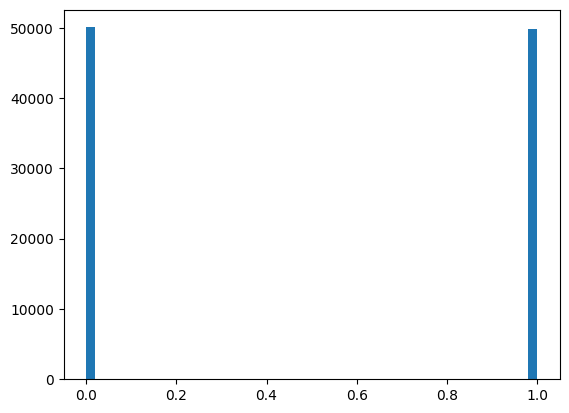

In [6]:
plt.figure()
temp_data = np.concatenate(temp_data, axis=0)
plt.hist(temp_data, bins=50)

(array([289287.,  38291.,  23578.,  17409.,  13965.,  11812.,  10026.,
          8977.,   8276.,   7502.,   7145.,   6708.,   6338.,   6069.,
          5794.,   5693.,   5277.,   5316.,   5105.,   5128.,   4969.,
          4852.,   4713.,   4917.,   4853.,   4760.,   4777.,   4788.,
          4781.,   4841.,   5104.,   4971.,   5064.,   5267.,   5296.,
          5670.,   5945.,   6217.,   6628.,   6842.,   7536.,   8157.,
          8794.,   9780.,  11499.,  13477.,  16318.,  22529.,  35419.,
        273540.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

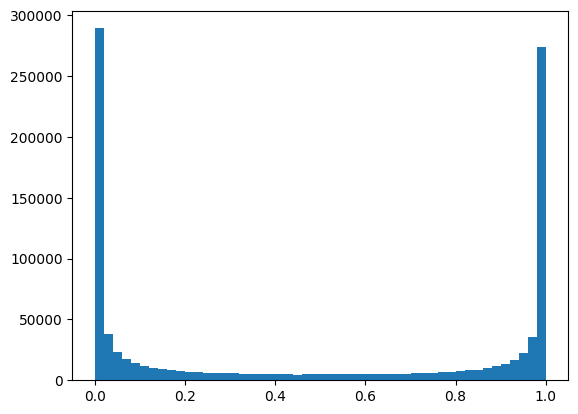

In [7]:
plt.figure()
plt.hist(np.concatenate(temp_data2, axis=0), bins=50)